In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from camb import model, initialpower

In [2]:
def get_Pk(cosmo_pars):
    As, ns, H0, ombh2, omch2 = cosmo_pars
    #Now get matter power spectra and sigma8 at redshift 0 and 0.8
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2)
    pars.InitPower.set_params(As=As, ns=ns)
    #Note non-linear corrections couples to smaller scales than you want
    pars.set_matter_power(redshifts=[0.], kmax=2.0)

    #Linear spectra
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    kh, z, pk = results.get_matter_power_spectrum(minkh=1e-3, maxkh=1, npoints = 2000)
    s8 = np.array(results.get_sigma8())
    
    return kh, pk[0], s8

In [3]:
k_min = 0.01
k_max = 0.1
N_bins = 21

k_bins = np.logspace(np.log10(k_min), np.log10(k_max), N_bins)

In [4]:
from scipy.interpolate import interp1d
from scipy.integrate import quad

EPS_REL = 1e-4

def integration_numerator(u, pk_interp):
    kh = np.exp(u)
    jacobian = kh
    return pk_interp(kh) * kh * kh * jacobian

def integration_denominator(u):
    kh = np.exp(u)
    jacobian = kh
    return kh * kh * jacobian

def integration_k_bincentre(u):
    kh = np.exp(u)
    jacobian = kh
    return kh * kh * kh * jacobian

def get_binned_Pk(kh, pk, k_bins):
    pk_interp = interp1d(kh, pk)
    binned_Pk_list = []
    binned_k_list = []
    for i in range(len(k_bins) - 1):
        u_lo = np.log(k_bins[i])
        u_hi = np.log(k_bins[i+1])
        I_n, _ = quad(integration_numerator, u_lo, u_hi, epsrel=EPS_REL, args=(pk_interp,))
        I_d, _ = quad(integration_denominator, u_lo, u_hi, epsrel=EPS_REL)
        I_k, _ = quad(integration_k_bincentre, u_lo, u_hi, epsrel=EPS_REL)
        
        Pk_i = I_n / I_d
        k_i  = I_k / I_d
        
        binned_Pk_list.append(Pk_i)
        binned_k_list.append(k_i)
        
    return np.array(binned_k_list), np.array(binned_Pk_list)

def compute_datavector(cosmo_pars):
    kh, pk, _ = get_Pk(cosmo_pars)
    _, Pk_binned = get_binned_Pk(kh, pk, k_bins)
    return Pk_binned

In [5]:
cosmo_pars_fid = np.array([2e-9, 0.97, 70., 0.0228528, 0.1199772])

kh_fid, pk_fid, s8 = get_Pk(cosmo_pars_fid)
binned_k, binned_Pk_fid = get_binned_Pk(kh_fid, pk_fid, k_bins)

In [6]:
delta_k = (k_bins[1:] - k_bins[:-1])
# Volume of NGC-High-z chunk (See eqn A8 of https://arxiv.org/pdf/2009.00622.pdf)
V = 2.78 * 10**9      
Pk_cov = 4 * np.pi**2 * binned_Pk_fid**2 / binned_k**2 / delta_k / V

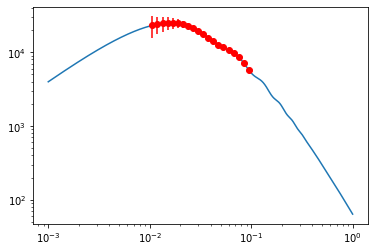

In [7]:
plt.loglog(kh_fid, pk_fid)
plt.errorbar(binned_k, binned_Pk_fid, np.sqrt(Pk_cov), color='r', fmt='o')
plt.show()

## Initialize a Latin Hypercube

In [8]:
from pyDOE import lhs

N_dim = 5

cosmo_prior = np.array([[1.2e-9, 2.7e-9],
                       [0.87, 1.07],
                       [55, 91],
                       [0.01, 0.04],
                       [0.002, 0.5]])

def get_cosmo_lhs_samples(N_samples, cosmo_prior):
    lhs_samples = lhs(N_dim, N_samples)
    cosmo_samples = cosmo_prior[:,0] + (cosmo_prior[:,1] - cosmo_prior[:,0]) * lhs_samples
    return cosmo_samples

In [9]:
N_lhs_samples = 100

train_cosmo_samples = get_cosmo_lhs_samples(N_lhs_samples, cosmo_prior)

In [10]:
from tqdm import tqdm
from multiprocessing import Pool

def calculate_datavector_batch(train_cosmo_samples):
    """
    Function to calculate the data vectors for a batch of training samples
    """
    train_dv_list = []
    with Pool() as p:
        train_dv_list = list(tqdm(p.imap(compute_datavector, train_cosmo_samples), total=len(train_cosmo_samples)))
    return np.array(train_dv_list)    

In [11]:
train_dv_arr = calculate_datavector_batch(train_cosmo_samples)

100%|██████████| 100/100 [00:37<00:00,  2.69it/s]


## Train the Neural network emulator

In [12]:
dv_fid = compute_datavector(cosmo_pars_fid)
dv_std = np.sqrt(Pk_cov)
OUTPUT_DIM = 20

In [13]:
from emulator import NNEmulator
import torch

def get_trained_nn_emu(train_cosmo_samples, train_dv_arr):
    """
    Get the trained NN emulator given the training parameters and data vectors
    """
    emu = NNEmulator(N_dim, OUTPUT_DIM, dv_fid, dv_std)
    emu.train(torch.Tensor(train_cosmo_samples), torch.Tensor(train_dv_arr))
    return emu

In [14]:
emu = get_trained_nn_emu(train_cosmo_samples, train_dv_arr)

Loss: 0.041858233511447906: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


## Sample using the emulator

In [15]:
dv_obs = dv_fid

def ln_prior(theta):
    for i in range(N_dim):
        if (theta[i] < cosmo_prior[i,0]) or (theta[i] > cosmo_prior[i,1]):
            return -np.inf
    return 0.
        
def ln_lkl(theta):
    dv_pred = emu.predict(torch.Tensor(theta))[0]
    delta_dv = (dv_pred - dv_obs)
    return -0.5 * np.sum(delta_dv**2 / Pk_cov)

def ln_prob(theta, temper):
    return ln_prior(theta) + temper * ln_lkl(theta)

In [16]:
import emcee
import os

os.environ["OMP_NUM_THREADS"] = "1"

N_MCMC        = 5000
N_WALKERS     = 40
NDIM_SAMPLING = 5

theta0    = cosmo_pars_fid
theta_std = np.array([0.01 * 2e-9, 0.01, 1., 0.001, 0.01])

# Starting position of the emcee chain
pos0 = theta0[np.newaxis] + theta_std[np.newaxis] * np.random.normal(size=(N_WALKERS, NDIM_SAMPLING))

def sample_emu(temper=1.):
    with Pool() as pool:
        emu_sampler = emcee.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, ln_prob, args=(temper,), pool=pool)
        emu_sampler.run_mcmc(pos0, N_MCMC, progress=True)
    return emu_sampler

In [17]:
TEMPER = 0.01

In [18]:
tempered_sampler = sample_emu(TEMPER)

100%|██████████| 5000/5000 [00:37<00:00, 132.94it/s]


In [19]:
def plot_emcee_chain(sampler, N):
    fig, ax = plt.subplots(N,1,figsize=(10, 2.5 * N))
    for i in range(N):
        ax[i].plot(sampler.chain[:,:,i].T, 'k-', lw=0.3)

    plt.show()    

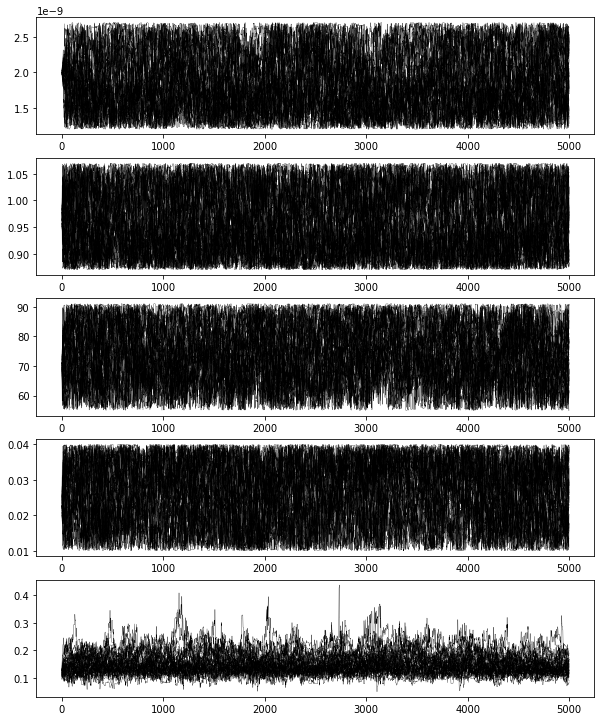

In [20]:
plot_emcee_chain(tempered_sampler, NDIM_SAMPLING)

In [21]:
N_BURN_IN = 3000
N_THIN    = 10

tempered_samples = tempered_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))

In [22]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

from getdist import plots, MCSamples
import getdist


def plot_cosmo_contours(sample_list, legend_labels):
    names = ['As', 'ns', 'H0', 'omegab', 'omegac']
    labels =  ['As', 'ns', 'H0', 'omega b', 'omega c']
    
    cosmo_truth = [2e-9, 0.97, 69., 0.0228528, 0.1199772]
    truth_dict = {}
    for name, truth in zip(names, cosmo_truth):
        truth_dict[name] = truth
        
    getdist_samples = []
    for samples, legend_label in zip(sample_list, legend_labels):
        cosmo_samples = samples[:,:5]
        getdist_samples.append(MCSamples(samples=cosmo_samples,names = names, labels=labels, label=legend_label))
    
    g = plots.get_subplot_plotter()
    g.triangle_plot(getdist_samples, filled=True, markers=truth_dict)
    
    plt.show()

Removed no burn in


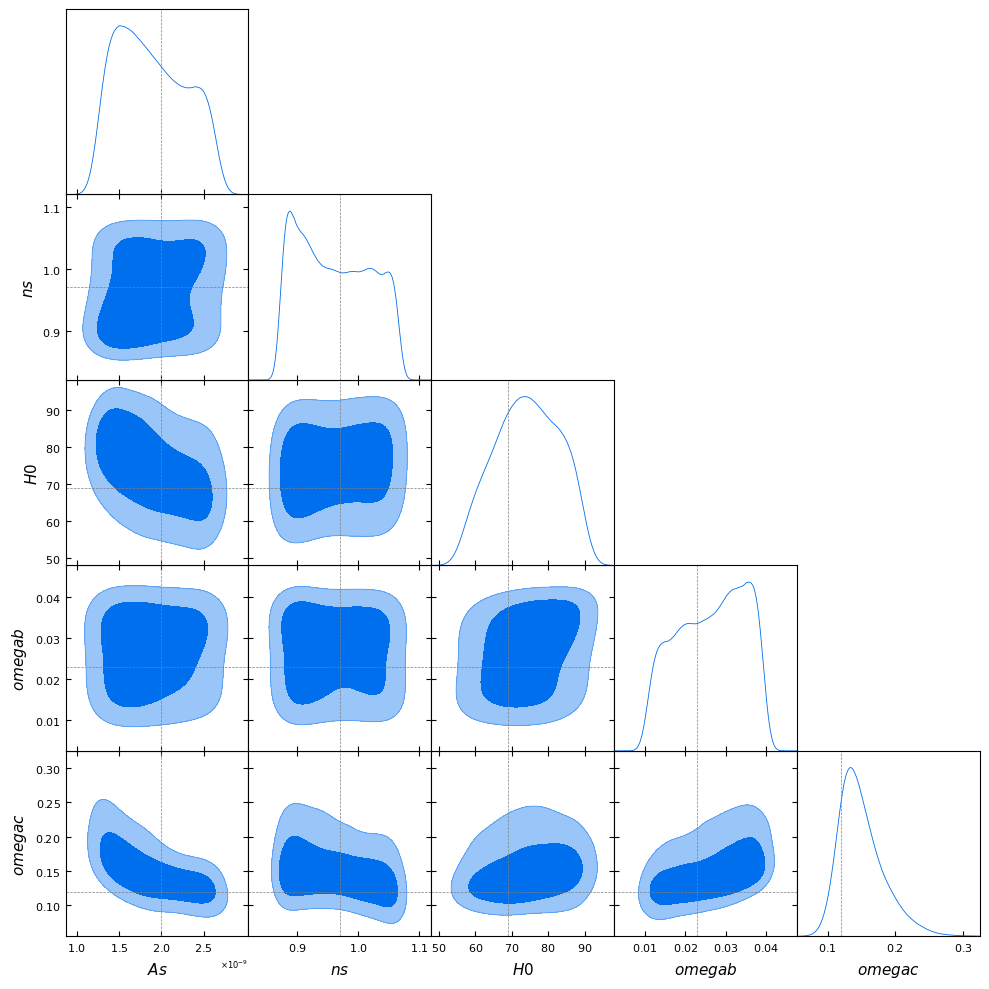

In [23]:
plot_cosmo_contours([tempered_samples], ['Tempered posterior'])

In [24]:
emu_sampler = sample_emu()

100%|██████████| 5000/5000 [00:37<00:00, 133.43it/s]


In [25]:
cosmo_samples = emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))

In [26]:
np.save('output/iteration_0/tempered_samples.npy', tempered_samples)
np.save('output/iteration_0/cosmo_samples.npy',    cosmo_samples)

## Calculate the data vector for a subsample from the tempered posterior and retrain the emulator

In [27]:
temper_schedule = [0.05, 0.15, 0.25, 0.5]
N_resample      = 200
N_iterations    = 4

In [ ]:
for i in range(1, N_iterations+1):
    print("Iteration %d"%(i))
    select_indices      = np.random.choice(np.arange(len(tempered_samples)), size=N_resample, replace=False)
    train_cosmo_samples_current = tempered_samples[select_indices]
    if(i==1):
        # We do not use the samples from the LHS step
        train_cosmo_samples = train_cosmo_samples_current
    else:
        train_cosmo_samples = np.vstack([train_cosmo_samples, train_cosmo_samples_current])
    print("Calculating data vectors...")
    train_dv_arr        = calculate_datavector_batch(train_cosmo_samples)
    print("Training emulator...")
    emu                 = get_trained_nn_emu(train_cosmo_samples, train_dv_arr)
    print("Sampling tempered posterior...")
    tempered_sampler    = sample_emu(temper_schedule[i-1])
    tempered_samples    = tempered_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))
    print("Sampling posterior...")
    emu_sampler         = sample_emu()
    cosmo_samples       = emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))
    np.save('output/iteration_%d/tempered_samples.npy'%(i), tempered_samples)
    np.save('output/iteration_%d/cosmo_samples.npy'%(i),    cosmo_samples)

Iteration 1
Calculating data vectors...


100%|██████████| 200/200 [01:21<00:00,  2.46it/s]


Training emulator...


Loss: 0.017699379473924637: 100%|██████████| 100/100 [00:45<00:00,  2.17it/s]

Sampling tempered posterior...



100%|██████████| 5000/5000 [00:37<00:00, 134.92it/s]


Sampling posterior...


100%|██████████| 5000/5000 [00:37<00:00, 134.89it/s]


Iteration 2
Calculating data vectors...


  2%|▏         | 6/400 [00:06<05:36,  1.17it/s]